# Chord Visualization
In this notebook, we extract main melody from audio representation of music and experiment with spectrogram and visualization of other styles inspired by Superatism.

## 1. Experiment with triangulation

### 1.1 Dog picture demo

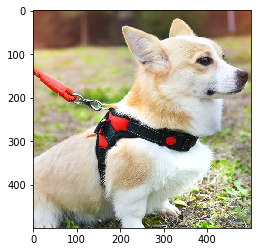

In [1]:
import numpy as np
import matplotlib.pylab as plt
from scipy.spatial import Delaunay

%matplotlib inline

im = plt.imread("test.jpg")
plt.imshow(im)

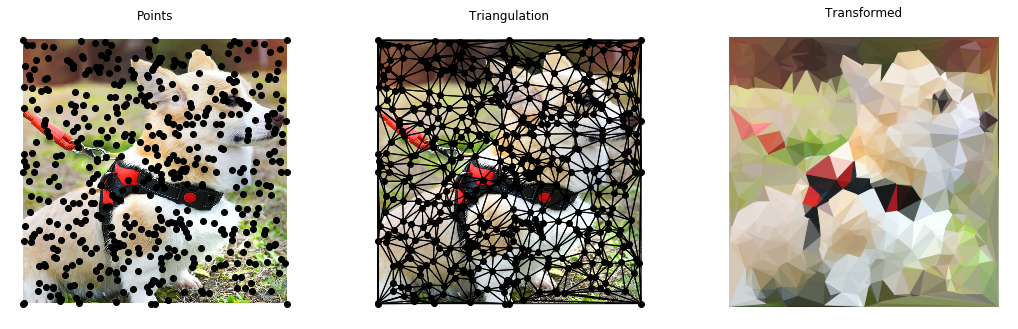

In [2]:
from triangulared import *

points = generate_uniform_random_points(im, n_points=500)
tri = Delaunay(points)

fig, axs = plt.subplots(ncols=3, figsize=(18,8), sharey=True)

ax = axs[0]
draw_image(ax, im)
draw_points(ax, points)
ax.set_title("Points")
set_axis_defaults(ax)


ax = axs[1]
draw_image(ax, im)
draw_points(ax, points)
draw_triangles(ax, tri.points, tri.vertices)
ax.set_title("Triangulation")
set_axis_defaults(ax)


ax = axs[2]
triangle_colours = get_triangle_colour(tri, im)
draw_triangles(ax, tri.points, tri.vertices, triangle_colours)
ax.set_title("Transformed")
set_axis_defaults(ax)

### 1.2 Byte visualization demo

In [85]:
file_name = "../../FMP_1/data/C5/FMP_C5_Audio_Beatles_HereComesTheSun_Beatles_1969-AbbeyRoad-07.wav"

file = open(file_name, 'rb')
content = file.read()
data = content[40000:]

ls = [int.from_bytes(data[i:i+2], "little", signed="true") for i in range(0, len(data), 2)]
print(ls[:100])

[884, 590, 172, 615, 906, 544, 241, 326, 299, 505, 228, 181, 434, -95, -696, -605, -131, 232, 9, -263, 39, 17, 115, 178, 132, 979, 260, 338, 927, 782, 979, 878, 642, 436, -102, -232, 116, -96, 287, 544, 421, 493, 779, 1084, 1174, 654, 591, 984, 1026, 545, 543, 445, 540, 573, 230, 446, 474, -26, -452, -406, 122, 439, -94, -201, 79, -281, -55, -476, -57, 294, -687, -229, -81, -192, -222, -162, -340, -573, -1175, -883, -760, -853, -302, -56, -31, 104, 424, 993, 838, 213, 205, 698, 457, -26, 17, -113, -21, -215, -354, -76]


In [4]:
def data_to_hsl(x):
    hue = abs(x)*10 % 360
    
    return hue

2916


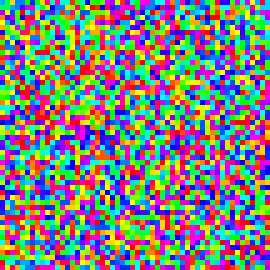

In [5]:
from PIL import Image, ImageDraw
from IPython.display import display

canvas_w, canvas_h = 270,270
square_n = 54
unit_w = 5

# color_arr = [(255,0,0),(0,0,0)] * 50
color_arr = [data_to_hsl(x) for x in ls[:square_n*square_n]]
print(len(color_arr))

img = Image.new("RGB",(canvas_w,canvas_h))

for i in range(square_n):
    for j in range(square_n):
        img1 = ImageDraw.Draw(img)
        coor = [(i*unit_w, j*unit_w), (i*unit_w+unit_w, j*unit_w+unit_w)]
        
        index = i * square_n + j
        color = "hsl({},{}%,{}%)".format(color_arr[index],100,50)
        
        img1.rectangle(coor, fill = color)  

display(img)

img.save("test2.jpg")

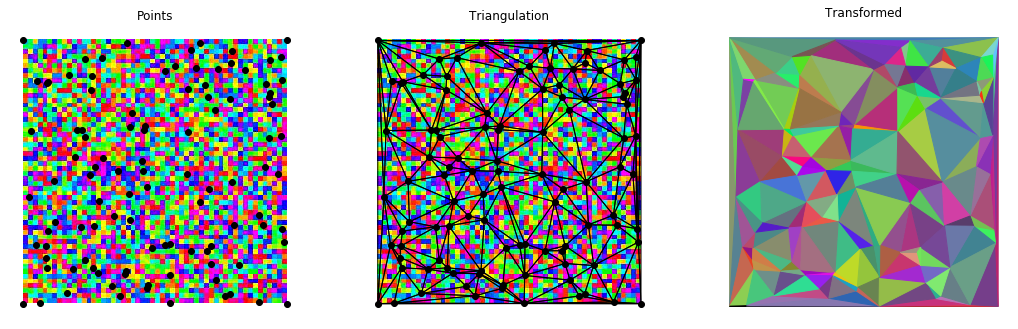

In [6]:
img = plt.imread("test2.jpg")

points = generate_uniform_random_points(img, n_points=100)
tri = Delaunay(points)

fig, axs = plt.subplots(ncols=3, figsize=(18,8), sharey=True)

ax = axs[0]
draw_image(ax, img)
draw_points(ax, points)
ax.set_title("Points")
set_axis_defaults(ax)


ax = axs[1]
draw_image(ax, img)
draw_points(ax, points)
draw_triangles(ax, tri.points, tri.vertices)
ax.set_title("Triangulation")
set_axis_defaults(ax)


ax = axs[2]
triangle_colours = get_triangle_colour(tri, img)
draw_triangles(ax, tri.points, tri.vertices, triangle_colours)
ax.set_title("Transformed")
set_axis_defaults(ax)

## 2. Experiment with chord visualization

In this experiment, we use Hotel California as an example to acquire the chord name and its length manually as strings. Then we try to visualize the chord and read it back into music. 

### 2.1 Row chords and conversion to color

We first manually input the length and chords of Hotel California.

In [7]:
import pandas as pd

chords = ["Bm","F#7","A","E","G","D","Em","F#7"]
chorus = ["G","D","F#7","Bm","G","D","Em","F#7"]

BPM = 75

music = pd.DataFrame(columns=["chords","length"])
music["chords"] = 2 * chords + chorus + 2 * chords + chorus + 2 * chords
music["length"] = 2 * 1/BPM

music

,chords,length
0,Bm,0.026667
1,F#7,0.026667
2,A,0.026667
3,E,0.026667
4,G,0.026667
...,...,...
59,E,0.026667
60,G,0.026667
61,D,0.026667
62,Em,0.026667


Then we come up with a dictionary such that dic[chord] = color 

In [8]:
color_dic = {"Bm":(255,0,0),"F#7":(255,255,0),"A":(0,255,0),"E":(0,255,255),"G":(255,0,255),"D":(0,0,255),"Em":(255,100,255)}


### 2.2 Visualizing chords

In [19]:
# create dic[coor] = inner_color
import math

image_size = (400,400)
chords_per_row = 8
ls = []

for i in range(len(music)):
    length = image_size[0] / chords_per_row
    x = (i % chords_per_row) * length + length / 2
    y = (i // chords_per_row) * length + length / 2
    
    color = color_dic[music["chords"].iloc[i]]
    corner_coor = [(0,0),(0,image_size[1]),(image_size[0],0),(image_size[0],image_size[1])]
    max_dis = max([math.sqrt((x - ele[0]) ** 2 + (y - ele[1]) ** 2) for ele in corner_coor])
    
    ls.append([int(x),int(y),color,max_dis])

coor_dic = pd.DataFrame(ls,columns=["x","y","inner_color","max_dis"])
coor_dic

,x,y,inner_color,max_dis
0,25,25,"(255, 0, 0)",530.330086
1,75,25,"(255, 255, 0)",496.235831
2,125,25,"(0, 255, 0)",465.026881
3,175,25,"(0, 255, 255)",437.321392
4,225,25,"(255, 0, 255)",437.321392
...,...,...,...,...
59,175,375,"(0, 255, 255)",437.321392
60,225,375,"(255, 0, 255)",437.321392
61,275,375,"(0, 0, 255)",465.026881
62,325,375,"(255, 100, 255)",496.235831


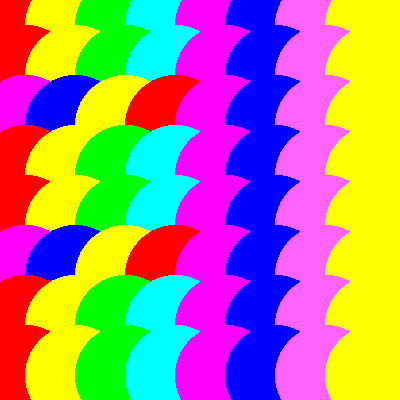

In [87]:
canvas_w, canvas_h = 400,400
unit_r = 50

img = Image.new("RGB",(canvas_w,canvas_h))

for i in range(len(coor_dic)):
    img1 = ImageDraw.Draw(img)
    pt = coor_dic.iloc[i]
    coor = [(pt["x"]-unit_r, pt["y"]-unit_r),(pt["x"]+unit_r, pt["y"]+unit_r)]
    color = pt["inner_color"]
    img1.ellipse(coor, fill=color) 

display(img)

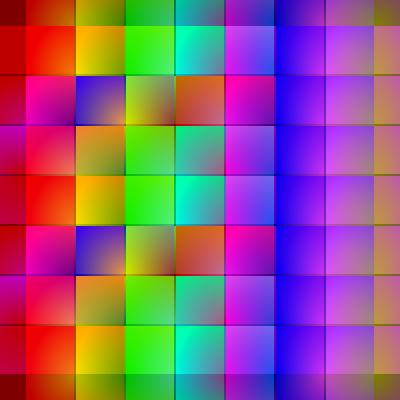

[127.5   0.    0. ]
[127.5 127.5   0. ]


In [95]:
imgsize = (400,400)

image = Image.new("RGB",image_size)
color_arr = np.zeros((image_size[0],image_size[1],3))

for i in range(len(coor_dic)):
    
    innerColor = coor_dic["inner_color"].iloc[i]
    outerColor = coor_dic["inner_color"].iloc[i-1] if i % chords_per_row != 0 else coor_dic["inner_color"].iloc[i-chords_per_row]
    a = coor_dic["x"].iloc[i]
    b = coor_dic["y"].iloc[i]
    maxDistance = 49

    x_range = [max(a-maxDistance,0),min(a+maxDistance,imgsize[0])]
    y_range = [max(b-maxDistance,0),min(b+maxDistance,imgsize[1])]

    for y in range(y_range[0],y_range[1]):
        for x in range(x_range[0],x_range[1]):

            distanceToCenter = math.sqrt((x - a) ** 2 + (y - b) ** 2)
            distanceToCenter = float(distanceToCenter) / maxDistance

            new_r = outerColor[0] * distanceToCenter + innerColor[0] * (1 - distanceToCenter)
            new_g = outerColor[1] * distanceToCenter + innerColor[1] * (1 - distanceToCenter)
            new_b = outerColor[2] * distanceToCenter + innerColor[2] * (1 - distanceToCenter)

            cur_r, cur_g, cur_b = color_arr[x,y]
            color_arr[x,y] = [min((cur_r+new_r)/2,255),min((cur_g+new_g)/2,255), min((cur_b+new_b)/2,255)]



for i in range(image_size[1]):
    for j in range(image_size[0]):
        
        color = tuple(color_arr[i][j].astype(int))
        image.putpixel((i,j), color)

display(image)

print(color_arr[25][25])
print(color_arr[75][25])

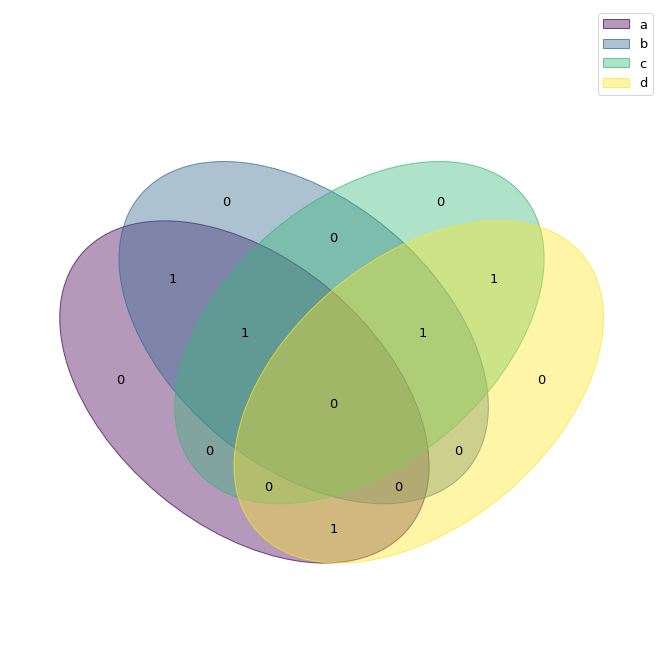

In [81]:
from venn import venn
d = [[1,2,3],[2,3,4],[3,4,5],[4,5,1]]
labels = ['a','b','c','d']
sets = {
    labels[0]: set(d[0]),
    labels[1]: set(d[1]),
    labels[2]: set(d[2]),
    labels[3]: set(d[3])
}
fig, ax = plt.subplots(1, figsize=(16,12))
venn(sets, ax=ax)

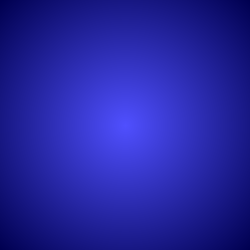

In [11]:
imgsize = (250, 250) #The size of the image

image = Image.new('RGB', imgsize) #Create the image

innerColor = [80, 80, 255] #Color at the center
outerColor = [0, 0, 80] #Color at the corners


for y in range(imgsize[1]):
    for x in range(imgsize[0]):

        #Find the distance to the center
        distanceToCenter = math.sqrt((x - imgsize[0]/2) ** 2 + (y - imgsize[1]/2) ** 2)

        #Make it on a scale from 0 to 1
        distanceToCenter = float(distanceToCenter) / (math.sqrt(2) * imgsize[0]/2)

        #Calculate r, g, and b values
        r = outerColor[0] * distanceToCenter + innerColor[0] * (1 - distanceToCenter)
        g = outerColor[1] * distanceToCenter + innerColor[1] * (1 - distanceToCenter)
        b = outerColor[2] * distanceToCenter + innerColor[2] * (1 - distanceToCenter)


        #Place the pixel        
        image.putpixel((x, y), (int(r), int(g), int(b)))

display(image)

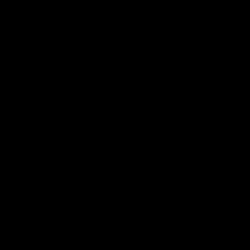

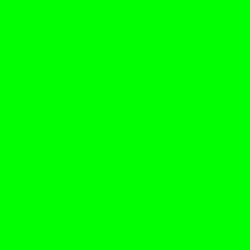

In [12]:
image_size = (250,250)

image = Image.new("RGB",image_size)
# color_arr = np.array([(255,0,0)]*image_size[0]*image_size[1]).reshape(image_size[0],image_size[1],3)
color_arr = np.zeros((image_size[0],image_size[1],3))
# print(color_arr)
for i in range(image_size[1]):
    for j in range(image_size[0]):

        color = tuple(color_arr[i][j].astype(int))
        image.putpixel((i,j), color)

display(image)

color_arr[:,:,1] += 255

for i in range(image_size[1]):
    for j in range(image_size[0]):
        
        color = tuple(color_arr[i][j].astype(int))
        image.putpixel((i,j), color)
display(image)